In [1]:
import sys

sys.path.append('..')

In [2]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
from core.loader.image_loader import ImageLoader
from core.embed.face import FaceEmbedder
from PIL import Image

In [3]:
loader = ImageLoader("./datasets/people", auto_load=True)
embedder = FaceEmbedder()

In [18]:
def crop_resize(img, box, image_size):
    x = box[0]
    y = box[1]
    w = box[2] - x
    h = box[3] - y

    out = img.crop(box).copy().resize((image_size, image_size), Image.BILINEAR)
    return out

In [4]:
from tqdm import tqdm

embeddings = []
ids = []
img_map = {}
for key, img in tqdm(loader.iter(), total=len(loader.image_data)):
    embedder.embed(img)
    img_map[img.id] = img
    for face_id, face in img.faces.items():
        embeddings.append(face["embedding"].flatten())
        ids.append((img.id, face_id))

100%|██████████| 39/39 [00:56<00:00,  1.45s/it]


In [5]:
embeddings = np.array(embeddings)

In [6]:
cluster_pred = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=2).fit_predict(embeddings)

In [7]:
clusters = []
for c in np.unique(cluster_pred):
    if c != -1:
        clusters.append([ids[i] for i in np.where(cluster_pred == c)[0]])

In [9]:
# lenth of clusters
for i, c in enumerate(clusters):
    print(f"Cluster {i}: {len(c)}")

Cluster 0: 8
Cluster 1: 4
Cluster 2: 4
Cluster 3: 15


In [10]:
clusters[0][0][0]

'8095ea7c-5ede-4471-b99c-d687a946a7e2'

In [15]:
def get_cluster_images(cluster):
    cluster_imgs = []
    for cluster in clusters:
        temp = []
        for c in cluster:
            img_id, _ = c
            temp.append(img_map[img_id].image)
        cluster_imgs.append(temp)
    return cluster_imgs

In [12]:
def plot_cluster(cluster_imgs):
    for i, cluster in enumerate(cluster_imgs):
        print(f"Cluster {i}")
        fig, axs = plt.subplots(1, len(cluster))
        for j, img in enumerate(cluster):
            axs[j].imshow(img)
            axs[j].axis("off")
        plt.show()
        plt.close()

Cluster 0


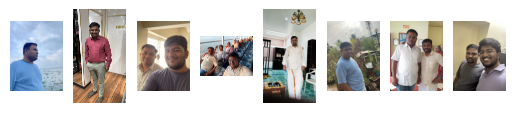

Cluster 1


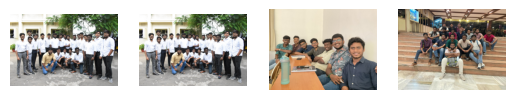

Cluster 2


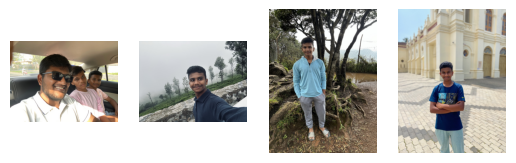

Cluster 3


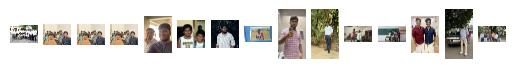

In [17]:
cluster_imgs = get_cluster_images(clusters)
plot_cluster(cluster_imgs)

Cluster 0


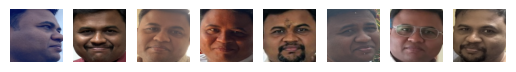

In [37]:
imgs = []
for idx, face_id in clusters[0]:
    img = loader.image_data[idx].image
    face = loader.get_face(idx, face_id)["facial_area"]
    imgs.append(crop_resize(img, face, 160))
plot_cluster([imgs])

## Community Detection

In [38]:
from sentence_transformers import util


def community_detection(embeddings, threshold, min_community_size=2, init_max_size=500):
    cos_scores = util.cos_sim(embeddings, embeddings)

    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [39]:
clusters = community_detection(embeddings, threshold=0.72, min_community_size=2, init_max_size=5)
print("No of clusters:", len(clusters))
for c in clusters:
    print(len(c))

No of clusters: 8
6
6
4
4
3
3
2
2


In [40]:
cluster_imgs = []
for cluster in clusters:
    temp = []
    for c in cluster:
        img_id, _ = ids[c]
        temp.append(img_map[img_id])
    cluster_imgs.append(temp)

In [41]:
cluster_embeddings = []
for cluster in clusters:
    temp = []
    for c in cluster:
        temp.append(embeddings[c])
    cluster_embeddings.append(temp)

In [42]:
cluster_centroids = []
for cluster in cluster_embeddings:
    cluster_centroids.append(np.mean(cluster, axis=0))

In [43]:
similar_centroid_map = {}
for i, c in enumerate(cluster_centroids):
    temp = []
    for j, c2 in enumerate(cluster_centroids):
        if i != j:
            temp.append((j, util.cos_sim(c, c2)[0][0].item()))
    temp = sorted(temp, key=lambda x: x[1], reverse=True)
    similar_centroid_map[i] = temp[:3]

In [44]:
threshold = 0.7
for i, c in enumerate(cluster_centroids):
    for j, sim in similar_centroid_map[i]:
        if sim > threshold:
            print(f"Cluster {i} similar to Cluster {j} with similarity {sim}")

Cluster 0 similar to Cluster 7 with similarity 0.7535132169723511
Cluster 1 similar to Cluster 2 with similarity 0.7146952748298645
Cluster 2 similar to Cluster 1 with similarity 0.7146952748298645
Cluster 7 similar to Cluster 0 with similarity 0.7535132169723511


In [45]:
clusters

[[5, 6, 22, 31, 51, 55],
 [16, 28, 37, 38, 52, 53],
 [27, 50, 35, 43],
 [34, 4, 58, 0],
 [10, 40, 11],
 [12, 9, 13],
 [15, 18],
 [46, 63]]

In [66]:
new_clusters = []
threshold = 0.7
seen = set()
for i, c in enumerate(cluster_centroids):
    for j, sim in similar_centroid_map[i]:
        if sim > threshold and j not in seen:
            curr_cluster = clusters[i] + clusters[j]
            new_clusters.append(clusters[i] + clusters[j])
            seen.add(j)
            seen.add(i)
    if i not in seen:
        new_clusters.append(clusters[i])

In [67]:
len(cluster_centroids), len(new_clusters)

(8, 6)

In [68]:
new_clusters

[[5, 6, 46, 51, 22, 55, 63, 31],
 [35, 37, 38, 43, 16, 50, 52, 53, 27, 28],
 [34, 4, 58, 0],
 [10, 40, 11],
 [12, 9, 13],
 [15, 18]]

In [69]:
cluster_imgs = []
for cluster in new_clusters:
    temp = []
    for c in cluster:
        img_id, _ = ids[c]
        temp.append(img_map[img_id].image)
    cluster_imgs.append(temp)

Cluster 0


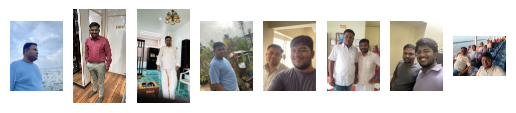

Cluster 1


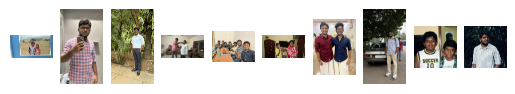

Cluster 2


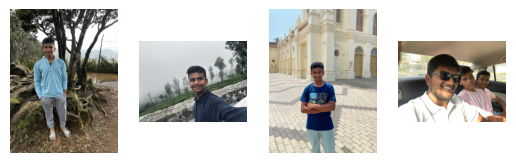

Cluster 3


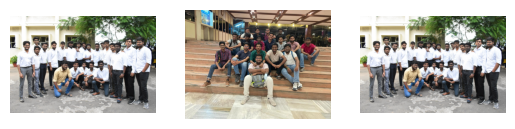

Cluster 4


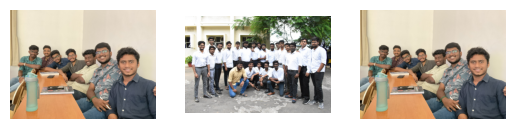

Cluster 5


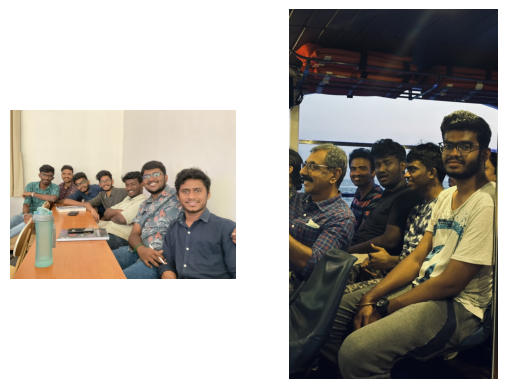

In [70]:
plot_cluster(cluster_imgs)

Cluster 0


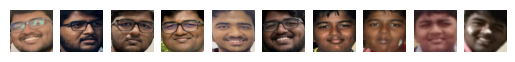

In [61]:
imgs = []
for idx in new_clusters[1]:
    img = img_map[ids[idx][0]].image
    face = img_map[ids[idx][0]].faces[ids[idx][1]]['facial_area']
    imgs.append(crop_resize(img, face, 160))
plot_cluster([imgs])

In [65]:
import pickle
with open("loader.pkl", "wb") as f:
    pickle.dump(loader, f)